In [12]:
from cmr import GranuleQuery, CollectionQuery, VariableQuery
import datetime
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from osgeo import gdal
import rasterio
import concurrent.futures
import backoff
from rasterio.errors import RasterioIOError
import requests
import boto3
from rasterio.session import AWSSession
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
df_hls = gpd.read_file('hls_metadata_with_linked_dswx.geojson')

In [3]:
df_hls.columns

Index(['granule_id', 'time_acquired', 'time_updated', 'B04_link',
       'time_acq_str', 'mgrs_tile_id', 'accode', 'add_offset', 'area_or_point',
       'arop_ave_xshift(meters)', 'arop_ave_yshift(meters)', 'arop_ncp',
       'arop_rmse(meters)', 'arop_s2_refimg', 'cloud_coverage',
       'hls_processing_time', 'horizontal_cs_name', 'l1_processing_time',
       'landsat_product_id', 'landsat_scene_id', 'long_name',
       'mean_sun_azimuth_angle', 'mean_sun_zenith_angle',
       'mean_view_azimuth_angle', 'mean_view_zenith_angle',
       'nbar_solar_zenith', 'ncols', 'nrows', 'ovr_resampling_alg',
       'processing_level', 'scale_factor', 'sensing_time', 'sensor',
       'sentinel2_tileid', 'spatial_coverage', 'spatial_resolution',
       'tirs_ssm_model', 'tirs_ssm_position_status', 'ulx', 'uly',
       'usgs_software', '_fillvalue', 'datastrip_id', 'horizontal_cs_code',
       'l1c_image_quality', 'msi band 01 bandpass adjustment slope and offset',
       'msi band 02 bandpass adjus

In [6]:
# Sensing Time
df_hls.time_acquired = df_hls.time_acquired.map(pd.to_datetime)
# Time Inngested
df_hls.time_updated = df_hls.time_updated.map(pd.to_datetime)
# Processing time
df_hls.hls_processing_time = df_hls.hls_processing_time.map(pd.to_datetime)

# Lags

In [48]:
def plot_lag(t0, t1, xlabel=None):
    xlabel = xlabel or 'Lag (days)'
    lag = (t1 - t0).dt.total_seconds()
    lag_d = lag / 60 / 60 / 24

    m0 = lag_d.min()
    m1 = lag_d.max()
    
    fig, ax = plt.subplots()
    ax.hist(lag_d, alpha=.25, density=True, bins=50, range=(0, m1 + .25))
    ax.set_xlabel(xlabel)
    plt.show()
    
    print(pd.DataFrame(lag_d.describe()))

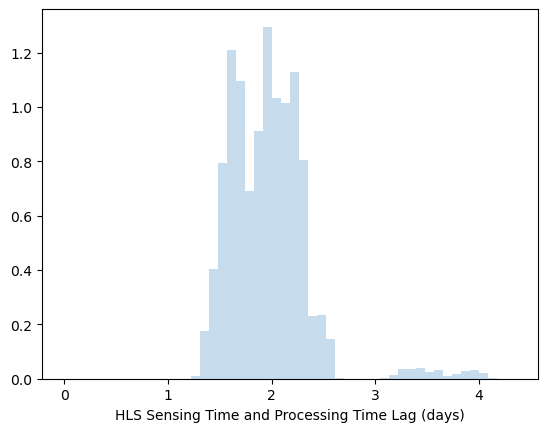

                  0
count  52260.000000
mean       1.964407
std        0.391630
min        1.285417
25%        1.677007
50%        1.945172
75%        2.174956
max        4.104077


In [49]:
plot_lag(df_hls.time_acquired, 
         df_hls.time_updated,
         xlabel ='HLS Sensing Time and Processing Time Lag (days)')

In [50]:
df_hls.time_acquired.dt.date.unique().tolist()

[datetime.date(2023, 5, 4),
 datetime.date(2023, 5, 5),
 datetime.date(2023, 5, 6),
 datetime.date(2023, 5, 7),
 datetime.date(2023, 5, 8),
 datetime.date(2023, 5, 9)]

In [79]:
df_hls_sub = df_hls[df_hls.time_acquired.dt.date == datetime.date(2023, 5, 5)].reset_index(drop=True)

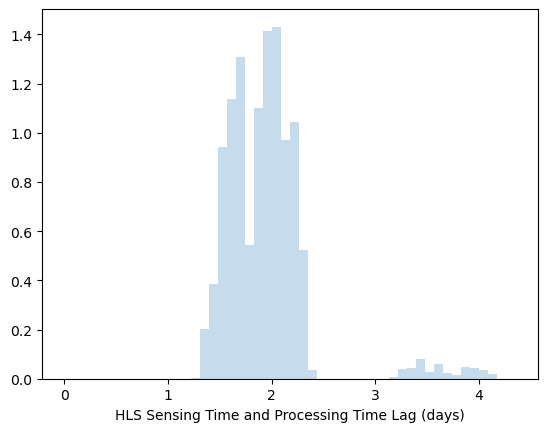

                  0
count  10671.000000
mean       1.943713
std        0.421677
min        1.291841
25%        1.668226
50%        1.922990
75%        2.098288
max        4.104077


In [80]:
plot_lag(df_hls_sub.time_acquired, 
         df_hls_sub.time_updated,
         xlabel ='HLS Sensing Time and Processing Time Lag (days)')

/tmp/ipykernel_274657/190021430.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(0.5, 1.0, 'May 5th (acquired)')

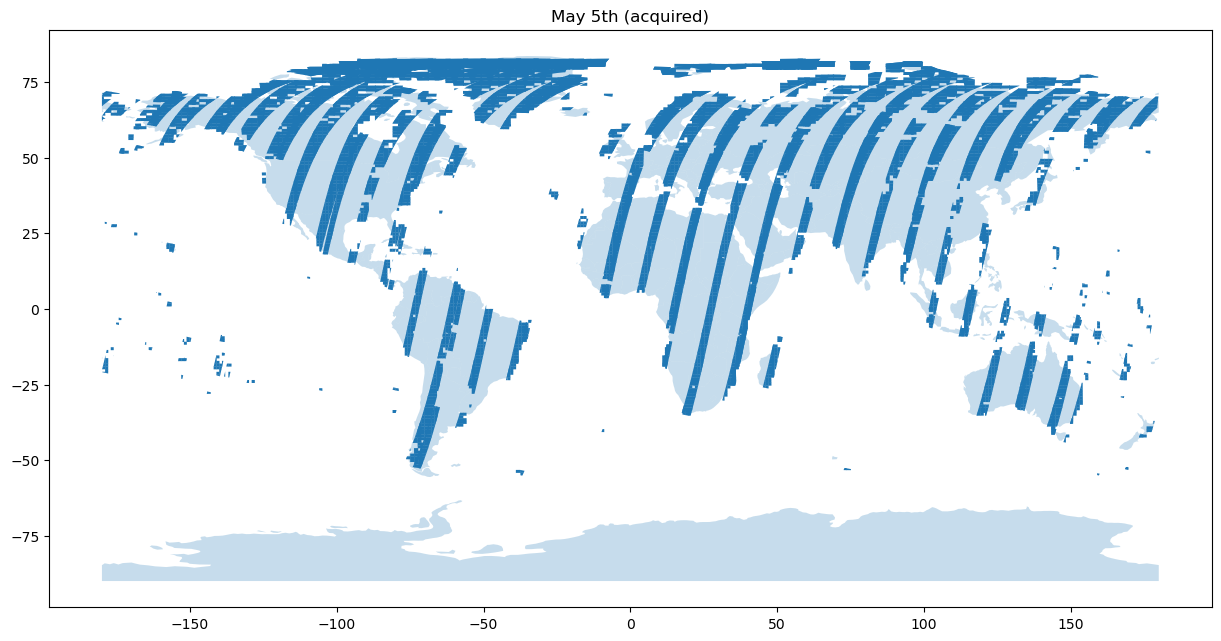

In [83]:
fig, ax=plt.subplots(figsize=(15, 10))
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.plot(ax=ax, alpha=.25)
df_hls_sub.plot(ax=ax)
ax.set_title('May 5th (acquired)')